# K-Means Clustering: Google Play Store Apps Analysis

## Business Use Case

The Objective of this exercise is to analyze the 10,000 Play Store apps and understand underlying relationships.  By creating clusters for these apps, we will look at the 13 available variables, determine which are important via means like principal component analysis (PCA), and provide the ability to dive further into individual clusters (listing which apps are in a given cluster).  Lastly, we'll provide next steps to take this analysis further.

## Imports and Setup

In [101]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import codecs

from sklearn.cluster import KMeans
from pylab import rcParams

#Format and Standardize Matplotlib
#Used for graphs/charts inside Jupyter
%matplotlib inline 
#Used for interactive graphs/charts outside Jupyter, including 3d model rotations
#%matplotlib qt 
rcParams['figure.figsize'] = 20,16
sb.set_style('whitegrid')

## Data Wrangling and Transformation

### Data Ingestion

We start off, by reading our csv file and looking at the first 5 records.

In [102]:
#Get the data and create a pandas dataframe
location = "C:/Users/B/Downloads/google-play-store-apps/googleplaystore.csv"
df=pd.read_csv(location)
df.head(5)

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
0,Photo Editor & Candy Camera & Grid & ScrapBook,ART_AND_DESIGN,4.1,159,19M,"10,000+",Free,0,Everyone,Art & Design,"January 7, 2018",1.0.0,4.0.3 and up
1,Coloring book moana,ART_AND_DESIGN,3.9,967,14M,"500,000+",Free,0,Everyone,Art & Design;Pretend Play,"January 15, 2018",2.0.0,4.0.3 and up
2,"U Launcher Lite – FREE Live Cool Themes, Hide ...",ART_AND_DESIGN,4.7,87510,8.7M,"5,000,000+",Free,0,Everyone,Art & Design,"August 1, 2018",1.2.4,4.0.3 and up
3,Sketch - Draw & Paint,ART_AND_DESIGN,4.5,215644,25M,"50,000,000+",Free,0,Teen,Art & Design,"June 8, 2018",Varies with device,4.2 and up
4,Pixel Draw - Number Art Coloring Book,ART_AND_DESIGN,4.3,967,2.8M,"100,000+",Free,0,Everyone,Art & Design;Creativity,"June 20, 2018",1.1,4.4 and up


In this case, the apps do not have characters that require specific encoding instructions.  If there were special characters, codecs provides an easy solution for this, with the sample code listed below:

In [103]:
with codecs.open(location, "r", encoding='utf-8', errors='ignore') as dataUTF:
    df = pd.read_csv(dataUTF)
df.columns = ['App','Category','Rating','Reviews','Size','Installs','Type','Price','Content Rating','Genres','Last Updated','Current Ver','Android Ver']
df.head(5)

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
0,Photo Editor & Candy Camera & Grid & ScrapBook,ART_AND_DESIGN,4.1,159,19M,"10,000+",Free,0,Everyone,Art & Design,"January 7, 2018",1.0.0,4.0.3 and up
1,Coloring book moana,ART_AND_DESIGN,3.9,967,14M,"500,000+",Free,0,Everyone,Art & Design;Pretend Play,"January 15, 2018",2.0.0,4.0.3 and up
2,"U Launcher Lite – FREE Live Cool Themes, Hide ...",ART_AND_DESIGN,4.7,87510,8.7M,"5,000,000+",Free,0,Everyone,Art & Design,"August 1, 2018",1.2.4,4.0.3 and up
3,Sketch - Draw & Paint,ART_AND_DESIGN,4.5,215644,25M,"50,000,000+",Free,0,Teen,Art & Design,"June 8, 2018",Varies with device,4.2 and up
4,Pixel Draw - Number Art Coloring Book,ART_AND_DESIGN,4.3,967,2.8M,"100,000+",Free,0,Everyone,Art & Design;Creativity,"June 20, 2018",1.1,4.4 and up


In [104]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10841 entries, 0 to 10840
Data columns (total 13 columns):
App               10841 non-null object
Category          10841 non-null object
Rating            9367 non-null float64
Reviews           10841 non-null object
Size              10841 non-null object
Installs          10841 non-null object
Type              10840 non-null object
Price             10841 non-null object
Content Rating    10840 non-null object
Genres            10841 non-null object
Last Updated      10841 non-null object
Current Ver       10833 non-null object
Android Ver       10838 non-null object
dtypes: float64(1), object(12)
memory usage: 1.1+ MB


The description of the dataset lets us know that there are 10,841 entries.  Additionally, 5 of the variables have nulls in their columns, with rating having the most (roughly 10% of the variable).  We'll have to make a judgment call, in which we either remove rating as a feature, keeping the rest of the records intact (10,833 would be the new amount), or remove the nulls across all variables.  Due to the large amount of individual apps, we'll remove the nulls.

In [105]:
#We'll create a new dataframe, to stop redundant loads of the metadata
df_tr = df
df_tr = df_tr.dropna()
df_tr.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9360 entries, 0 to 10840
Data columns (total 13 columns):
App               9360 non-null object
Category          9360 non-null object
Rating            9360 non-null float64
Reviews           9360 non-null object
Size              9360 non-null object
Installs          9360 non-null object
Type              9360 non-null object
Price             9360 non-null object
Content Rating    9360 non-null object
Genres            9360 non-null object
Last Updated      9360 non-null object
Current Ver       9360 non-null object
Android Ver       9360 non-null object
dtypes: float64(1), object(12)
memory usage: 1023.8+ KB


Now we'll need to look at the variables, as some of them (string variables) are not in the format we need (numerical inputs).  These variables include all but Rating.  For the App, we'll append the cluster, so we can know which App is in which cluster, but for now the index will serve as a placeholder, denoting the 9,360 data points.  We'll then turn Category into a true categorical variable, in which we can reference the original string name.

In [106]:
#Let's look at the unique names in the Category feature
df_tr.Category.unique()

array(['ART_AND_DESIGN', 'AUTO_AND_VEHICLES', 'BEAUTY',
       'BOOKS_AND_REFERENCE', 'BUSINESS', 'COMICS', 'COMMUNICATION',
       'DATING', 'EDUCATION', 'ENTERTAINMENT', 'EVENTS', 'FINANCE',
       'FOOD_AND_DRINK', 'HEALTH_AND_FITNESS', 'HOUSE_AND_HOME',
       'LIBRARIES_AND_DEMO', 'LIFESTYLE', 'GAME', 'FAMILY', 'MEDICAL',
       'SOCIAL', 'SHOPPING', 'PHOTOGRAPHY', 'SPORTS', 'TRAVEL_AND_LOCAL',
       'TOOLS', 'PERSONALIZATION', 'PRODUCTIVITY', 'PARENTING', 'WEATHER',
       'VIDEO_PLAYERS', 'NEWS_AND_MAGAZINES', 'MAPS_AND_NAVIGATION'], dtype=object)

In [107]:
#We'll transform the Category feature into a categorical data type and then apply this to the column, transforming the strings into numerics for the given category
df_tr.Category = pd.Categorical(df_tr.Category)
df_tr['Category'] = df_tr.Category.cat.codes
df_tr.head(5)

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py:2999: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
0,Photo Editor & Candy Camera & Grid & ScrapBook,0,4.1,159,19M,"10,000+",Free,0,Everyone,Art & Design,"January 7, 2018",1.0.0,4.0.3 and up
1,Coloring book moana,0,3.9,967,14M,"500,000+",Free,0,Everyone,Art & Design;Pretend Play,"January 15, 2018",2.0.0,4.0.3 and up
2,"U Launcher Lite – FREE Live Cool Themes, Hide ...",0,4.7,87510,8.7M,"5,000,000+",Free,0,Everyone,Art & Design,"August 1, 2018",1.2.4,4.0.3 and up
3,Sketch - Draw & Paint,0,4.5,215644,25M,"50,000,000+",Free,0,Teen,Art & Design,"June 8, 2018",Varies with device,4.2 and up
4,Pixel Draw - Number Art Coloring Book,0,4.3,967,2.8M,"100,000+",Free,0,Everyone,Art & Design;Creativity,"June 20, 2018",1.1,4.4 and up


In [108]:
#Dropping the following variables
df_tr2 = df_tr.drop(['App','Reviews','Size','Installs','Type','Price',
                     'Content Rating','Genres','Last Updated','Current Ver','Android Ver'], axis=1)
df_tr2.head(5)

,Category,Rating
0,0,4.1
1,0,3.9
2,0,4.7
3,0,4.5
4,0,4.3


### Feature Correlation and PCA Dimensionality Reduction

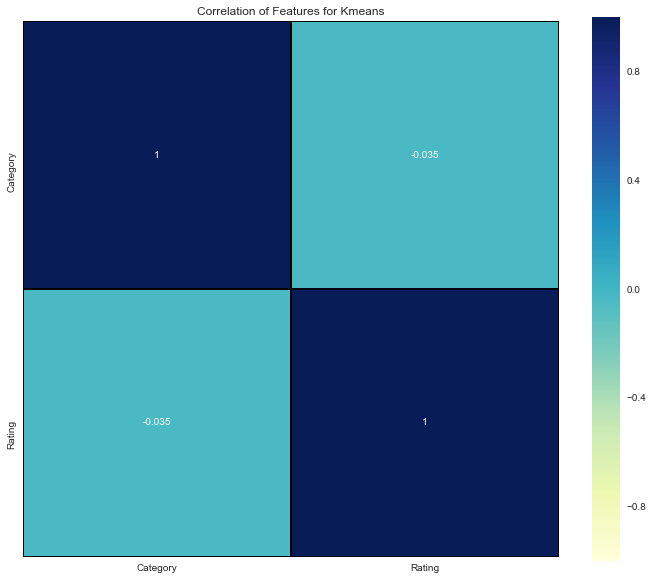

In [109]:
f, ax = plt.subplots(figsize=(12,10))
plt.title('Correlation of Features for Kmeans')
sb.heatmap(df_tr2.astype(float).corr(), linewidths=0.25, vmax=1.0, square=True,
          cmap='YlGnBu', linecolor='black', annot=True)

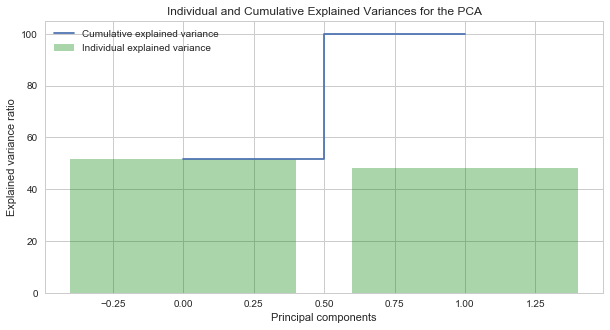

In [110]:
#Scale the features
X = df_tr2.values
from sklearn.preprocessing import StandardScaler
X_std = StandardScaler().fit_transform(X)

#Calculating Eigenvectors and Eigenvalues of Covariance Matrix
mean_vec = np.mean(X_std, axis=0)
cov_mat = np.cov(X_std.T)
eig_vals, eig_vecs = np.linalg.eig(cov_mat)

#Create a list of (eigenvalue, eigenvector) tuples
eig_pairs = [(np.abs(eig_vals[i]),eig_vecs[:,i]) for i in range(len(eig_vals))]

#Sort from high to low
eig_pairs.sort(key = lambda x: x[0], reverse=True)

#Calculation of Explained Variance from the Eigenvalues
tot = sum(eig_vals)
var_exp = [(i/tot)*100 for i in sorted(eig_vals, reverse=True)] #Individual explained variance
cum_var_exp = np.cumsum(var_exp) #Cumulative explained variance

#Plot out the Explained Variances Superimposed
plt.figure(figsize=(10,5))
plt.bar(range(len(var_exp)), var_exp, alpha=0.3333, align='center', label='Individual explained variance', color ='g')
plt.step(range(len(cum_var_exp)), cum_var_exp, where='mid',label='Cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal components')
plt.legend(loc='best')
plt.title('Individual and Cumulative Explained Variances for the PCA')
plt.show()

In [111]:
from sklearn.decomposition import PCA
pca2 = PCA(n_components=2)
x_2d = pca2.fit_transform(X_std)

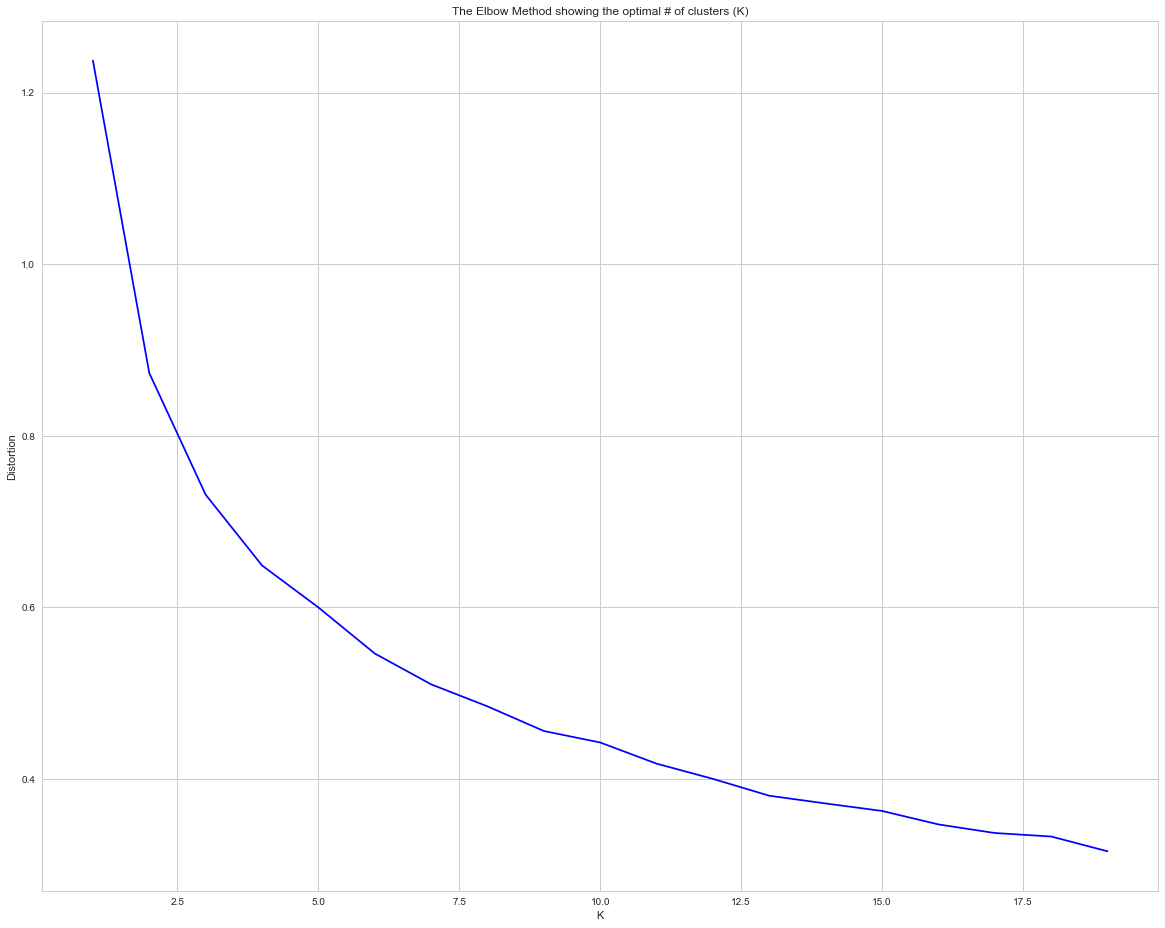

In [115]:
from scipy.spatial.distance import cdist

#To determine the # of clusters (k) via the elbow method
distortions = []
K=range(1,20)
for k in K:
    kmeanModel = KMeans(n_clusters=k).fit(x_2d)
    kmeanModel.fit(x_2d)
    distortions.append(sum(np.min(cdist(x_2d, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / x_2d.shape[0])
    
#Plot the elbow
plt.plot(K, distortions, 'bx-')
plt.xlabel('K')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal # of clusters (K)')
plt.show()

## Cluster Modeling

## Output

## Conclusion

## Next Steps

bafsdaf